In [ ]:
#@title Загрузим трансформеры и историю чата с G-drive

!pip install transformers
!gdown 1eVYJJzpt1nHYvHDa4xi3tgkeLtOAOGoO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1eVYJJzpt1nHYvHDa4xi3tgkeLtOAOGoO
To: /content/result.json
100% 79.2M/79.2M [00:00<00:00, 89.4MB/s]


In [ ]:
#@title Загрузим данные, почистим, и посмотрим что там 
#@markdown Здесь оставим только ччистый текст, длиной не меньше указанного количества символов
minimal_text_length = 75 #@param {type:"integer"}
import json 
import pandas as pd

with open('result.json') as f: data = json.load(f)['messages']
ms = pd.DataFrame.from_records(data[1:], index='id')[['from','text']]
ms = ms[ms.applymap(lambda x: isinstance(x, str)).all(axis=1)]
ms = ms[ms.applymap(lambda x: len(x)>=minimal_text_length).any(axis=1)]
ms

,from,text
id,,
2,Anton Kolonin,"Коллеги, всем привет! Ввиду задолбавшего нашес..."
35,Anton Kolonin,"Иллюстрация того, что любые абстрактные пробле..."
145,Alexander Teterkin,Там комментарии у видео можно почитать и стано...
152,Anton Kolonin,Обнаружил перевод собственной статьи в конце п...
163,Anton Kolonin,"""Переход от петард и фейерверков к пулям и сна..."
...,...,...
63029,Тео,"Что в таком случае является ""слоем"" в биологич..."
63030,Alexander Tsukanov,Этап параллельной обработки в любом виде. Напр...
63031,Alexander Tsukanov,"Суть демонстрации понятна, но это же вроде нич..."


In [ ]:
#@title сформируем выборки по избранным людям
from sklearn.model_selection import train_test_split
#@markdown Здесь укажем количество в обучающей выборке (в которой знаем, кто спикер)
#@markdown и на скольких будем проверять
train_length = 300 #@param {type:"integer"}
val_length = 15 #@param {type:"integer"}
#@markdown Чисто случайное число, что бы выборка одинаковая была
random_seed = 42 #@param {type:"integer"}
#@markdown Ники людей в квалратных скобках, в кавычках, через запятую
persons = ["Dim","Kilorad","Alexander Boldachev","Alexandr Tumanyan","Anton Kolonin"] #@param {type:"raw"}

mss = {}
trains = {}
vals = {} 

for pr in persons:
  mss.update({pr:ms[(ms['from']==pr)]})
  print(pr, len(mss[pr]), 'ms')
  all = mss[pr].sample(train_length+val_length,random_state=random_seed)
  train, test = train_test_split(all, test_size=15/315,random_state=random_seed)
  trains.update({pr: train})
  vals.update({pr: test})

vals

Dim 1970 ms
Kilorad 1731 ms
Alexander Boldachev 1146 ms
Alexandr Tumanyan 794 ms
Anton Kolonin 1167 ms


{'Dim':       from                                               text
 id                                                           
 56490  Dim  rust хорошо, но не для интеграционного тестиро...
 34385  Dim  Вот теперь вопросы хорошие! ) \n\n>>>Верхеуров...
 52015  Dim  Это хороший вопрос... Прям очень. Если бы я см...
 49757  Dim  Я не боюсь... Мне, к моему сожалению, приходит...
 51291  Dim  В наличии механизма автоматического поиска опт...
 58908  Dim  *разницей в том ,что проповедуют религию а про...
 57110  Dim  Зрение - одно из чувств, не? Элемент сенсорног...
 50118  Dim  Секундочку... тут все зависит от того, допуска...
 59451  Dim  Ну вы же понимаете, что это ответ не на базе с...
 58732  Dim  Я только не очень понимаю откуда взялась идея ...
 56999  Dim  Ну тут идея в чем... У меня есть-таки вербальн...
 36331  Dim  А почему вы думаете, что я эти вопросы не обсу...
 51216  Dim  Это в общем инверсная кинематика с учетом упру...
 53462  Dim  Бекпроп не обязателен, как и ИНС. В

In [ ]:
#@title Загрузим Берта
from transformers import AutoTokenizer, AutoModel
import torch
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
if torch.cuda.is_available():
  model.cuda()


In [ ]:
#@title Прогоним выборки через Берт
#@markdown Максимум фразы - все, что больше режем
maximal_text_length = 64 #@param {type:"integer"}
#@markdown Для коннкретно этой модели - 512 токенов (не букв!) максимум, меньше - можно

embeddings = {} 
emb_list = []
for pr in persons:
  _embeddings = []
  sentences = trains[pr].values.tolist()
  for i in range(train_length//100+ (1 if train_length % 100!=0 else 0)):
    encoded_input = tokenizer(sentences[i*100:i*100+100], padding=True, truncation=True, max_length=maximal_text_length, return_tensors='pt').to(model.device)
    with torch.no_grad():
      model_output = model(**encoded_input)
    _embeddings.append(mean_pooling(model_output, encoded_input['attention_mask']))
  embeddings.update({pr:torch.cat(_embeddings,dim=0).to('cpu').detach()})
  emb_list.append(embeddings[pr])

#kl_embeddings = []
#kl_sentences = tr_kl_ms.text.values.tolist()
#for i in range(3):
#  encoded_input = tokenizer(kl_sentences[i*100:i*100+100], padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
#  with torch.no_grad():
#    model_output = model(**encoded_input)
#  kl_embeddings.append(mean_pooling(model_output, encoded_input['attention_mask']))

all_emb = torch.cat(emb_list,dim=0)
all_emb.shape


torch.Size([1500, 1024])

In [ ]:
#@title Меточки
import numpy as np

classes=np.array([])
for i in range(len(persons)):
 classes = np.concatenate([classes, np.repeat(i, train_length)])

classes.shape

(1500,)

In [ ]:
#@title Построим проекцию на плоскость (2d)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random',perplexity=3).fit_transform(all_emb)
tsne.shape

(1500, 2)

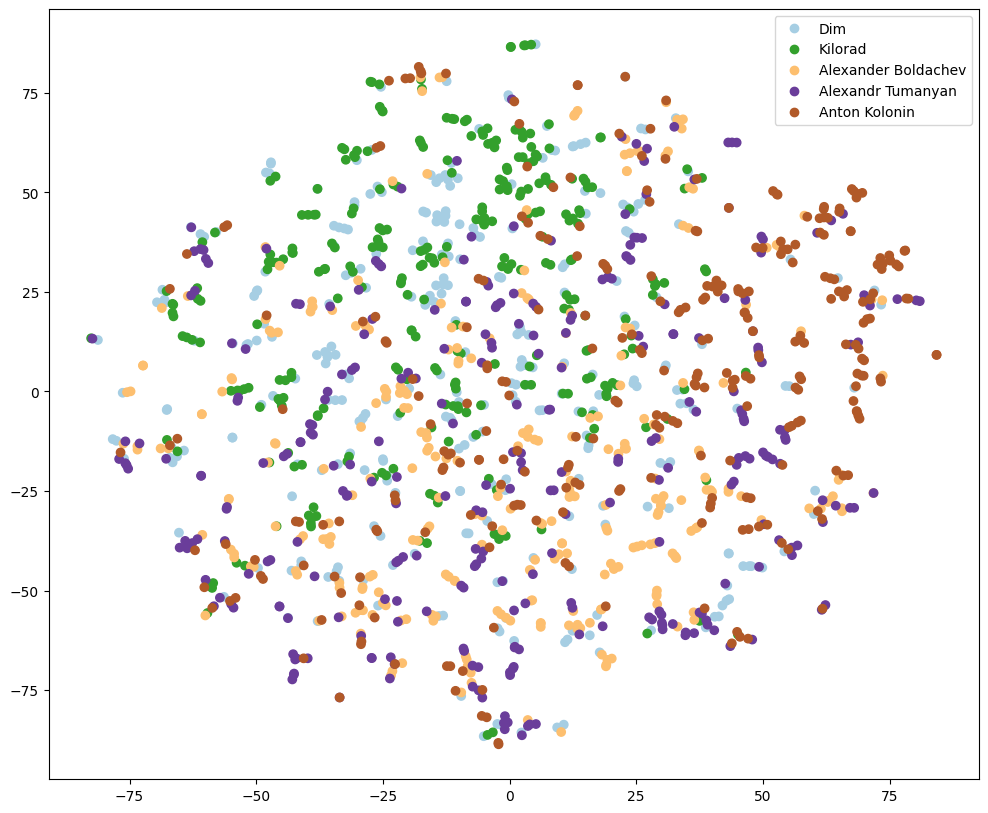

In [ ]:
#@title Визуализируем
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(10)
cax=ax.scatter(tsne[:,0],tsne[:,1],c=classes, cmap='Paired')
plt.legend(handles=cax.legend_elements()[0], labels=persons)

In [ ]:
#@title Обучем классификатор
#@markdown число соседей при определении спикера 
k_neighbors = 3 #@param {type:"integer"}
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(k_neighbors)
neigh.fit(all_emb, classes)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#@title Проверим как работает классификатор

for i in range(len(persons)):
  pr = persons[i]
  _sentences = vals[pr].text.values.tolist()  
  encoded_input = tokenizer(_sentences, padding=True, truncation=True, max_length=maximal_text_length, return_tensors='pt').to(model.device)
  with torch.no_grad():
    model_output = model(**encoded_input)
  _embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  print(pr,sum(neigh.predict(_embeddings.to('cpu').detach())==i),'of',val_length)

Dim 12 of 15
Kilorad 9 of 15
Alexander Boldachev 9 of 15
Alexandr Tumanyan 3 of 15
Anton Kolonin 4 of 15


In [ ]:
vals['Dim'].text.values.tolist()

['rust хорошо, но не для интеграционного тестирования же и проверок api... 😅 он же компилируемый, а тут надо что-то такое... скриптовое.',
 'Вот теперь вопросы хорошие! ) \n\n>>>Верхеуровнево мозг так работает, да. Но чтобы менять среду, надо знать как. Откуда это знание появится у трансформера,\n\nА откуда эти знания появляются у вас? Изначально вы или пассивно наблюдаете определенные цепочки в мироздании, или почти рандомно пробуете что-то изменить сами. У человека есть мощный мега-супер пупер хак: такие цепочки в сжатом и дистиллированном виде можно передавать друг другу в виде слов/текста... Т.е. все у вам есть - и элементы последовательностей и куски переходов между ними. Вам нужно просто правильно их скомбинировать друг с другом. \n\n\n >>> Я каждый день, заходя на кухню, вижу немытую посуду. Вдруг, в одно утро эта посуда исчезла (или стала помытой). Я должен срочно создать грязную посуду, чтобы модели стали равны! \n \n Почему? я же описал это на примере стола: все зависит от пр

In [ ]:
vals['Alexandr Tumanyan'].text.values.tolist()

['Слово "часто" ставит на глобальности крест. Любое уточняющие слово ставит этот крест, на практике.',
 'Изобретение пороха и далее по списку только позволяло еще успешнее человеку карабкаться на вершины. Чем ии отличается? Ничем.\n\n*Опасный человек может породить только свое опасное подобие и ничего больше..',
 'На рекомендательные системы 35% бюджета, а на перспективные технологии 11%..\nНичего не меняется.',
 'О, нет, тут как раз все просто и даже есть исследования на тему. Касаемся таламуса справа - лягушка смотрит вправо, слева - влево.',
 'Я не решал, что слова это единственный критерий  просто это единственный способ рассказать о происходящем другому человеку.\n\nЕсли интенсивность велика  то рука поднимается и наоборот. Получается, что подъёмом рулит некая интенсивность. Нет ее и привет. Кто же рулит интенсивностью? Понимаете? Вы можете сказать, что это вы задаёте интенсивность, но тогда возникнет вопрос а как вы этим сознательно управляете. Понимаете? Далее, очевидно, что льв

In [ ]:
vals['Anton Kolonin'].text.values.tolist()

['С тем что все графы - о связях, а все грамматики - о связи слов в предложени, спорить невозможно.\nПо существу - открываем обсуждаемую статью и читаем "Building compositional sentences (compounds) from building blocks (atoms)."',
 'Антропоморфизаторы скажут, что это само собой происходит в глубине глубоких нейросетей, только это недоступно нашему поверхностному взгляду...',
 'Кстати, предложение всем участникам, кто еще не докладывался на семинаре, рассказать в 2-3 предложениях, какую задачу они хотят решить путем общения в этой группе🙄',
 'Я так и не увидел ссылок на эту "грамматику", на парсер и файлы с моделями, дискуссия пришла к своему началу и стала беспредметной 😃',
 'Кто то в курсе, про какое совершенствование внутреннего генома в процессе обучения для развития интуиции, специфичной к предметной области, в следующих поколениях рассказывает спикер?',
 'Если код уже в открытом доступе, то - да - поддерживаю.\n\nНо алгоритм и код это разные вещи. Можно не блокировать общий абстр